In [1]:
!pip install --upgrade matplotlib

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed

In [3]:
stocks_searches = pd.read_csv('stocksSearches.csv', index_col=0)
n_features = stocks_searches.shape[1]
stocks_searches.head()

,btcClose,newsSearches,searches
date,,,
2016-10-02,610.892029,4.0,3.0
2016-10-03,612.132996,4.0,3.0
2016-10-04,610.203979,4.0,3.0
2016-10-05,612.510986,4.0,3.0
2016-10-06,613.020996,4.0,3.0


In [4]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :][last_training_predictions_df.columns[1]] < row[last_training_predictions_df.columns[1]], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  train_evaluate = ts[:-n_evaluations*n_test]
  last_training = train_evaluate[-n_steps:]
  print('Iteration 1 started')
  model.train(train_evaluate, n_epochs, batch_size)

  for i in reversed(range(1, n_evaluations + 1)):
    test_evaluate = ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    steps_to_predict = pd.concat([last_training, test_evaluate])

    predictions = model.predict(steps_to_predict)
    predictions = predictions.reshape(predictions.shape[0])
    predictions_ts = pd.DataFrame({test_evaluate.columns[0]: predictions}, test_evaluate.index)

    predictions_df = build_prediction_dataframe(last_training, predictions_ts)
    predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

    test_df = build_prediction_dataframe(last_training, test_evaluate)
    test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

    predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
    predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
    predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

    hits = predictions_and_test['equal'].sum()
    print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
    total_hits += hits
    total_tries += predictions_and_test.shape[0]

    print('Iteration {} started'.format(n_evaluations+1-i))
    new_train = pd.concat([last_training, test_evaluate])
    model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
    last_training = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

def print_effectiveness_day(cm, day):
  hits = cm[0][0] + cm[1][1]
  total = hits + cm[0][1] + cm[1][0]
  print("Day:", day, "Accuracy:", hits / total)

def print_effectiveness_by_day(confusion_matrix_list):
  for i in range(len(confusion_matrix_list)):
    print_effectiveness_day(confusion_matrix_list[i], i+1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10800     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 10,953
Trainable params: 10,953
Non-trainable params: 0
_________________________________________________________________
None
Iteration 1 started
Epoch 1/50
81/81 [==============================] - 2s 8ms/step - loss: 0.1326 - accuracy: 0.0000e+00 - val_loss: 0.0651 - val_accuracy: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0256 - accuracy: 0.0000e+00 - val_loss: 0.0287 - val_accuracy: 0.0000e+00
Epoch 4/50
81/81 [===========================

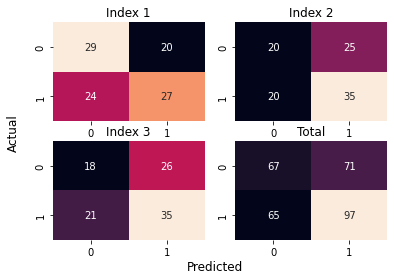

In [5]:
# from sklearn.metrics import mean_absolute_percentage_error
from VanillaMultivariableLSTM import VanillaLSTM
from StackedMultivariableLSTM import StackedLSTM
from BidirectionalMultivariableLSTM import BidirectionalLSTM
from ConvMultivariableLSTM import ConvLSTM
from CnnMultivariableLSTM import CnnLSTM

epochs = 50
batch_size = 16
n_steps = 5
n_outputs = 3
n_evaluations = 100
n_neurons = 50
n_seed = 0
optimizer = 'adam'
loss = 'mean_absolute_error'

seed(n_seed)
tf.random.set_seed(n_seed)
model = VanillaLSTM(n_neurons=n_neurons, n_steps=n_steps, n_features=n_features, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_searches, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [6]:
def score_from_cm(confusion_matrix_array):
  total_cm = sum(confusion_matrix_array)
  total_score = total_cm[0][0] + total_cm[1][1]

  score_by_index = [x[0][0] + x[1][1] for x in confusion_matrix_array]
  score =  { 
      'total_score': total_score,
      'score_by_index': score_by_index
    }
  return score

def score_model_from_dict(score_dict):
  n_index = len(score_dict['score_by_index'])
  score = score_dict['total_score'] * pow(10, n_index * 2)
  for i in range(n_index):
    score += score_dict['score_by_index'][i] * pow(10, (n_index-(i+1))*2)
  print("score:", score)
  return score

def take_score(elem):
    return elem['score']

def grid_search(model_class, ts, n_features, seeds=[0], optimizers=['adam'], losses=['mean_squared_error'], neurons=[50], steps=[1], n_outputs=3, epochs=[50], batch_sizes=[16], n_evaluations=10):
  models= list()
  n_combinations = len(seeds) * len(optimizers) * len(losses) * len(neurons) * len(steps) * len(epochs) * len(batch_sizes)
  print("Number of combinations to test:", n_combinations)
  starting_time = time.time()
  for n_seed in seeds:
    for optimizer in optimizers:
      for loss in losses:
        for n_neurons in neurons:
          for n_steps in steps:
            for n_epochs in epochs:
              for batch_size in batch_sizes:
                print("Seed: {}, Optimizer: {}, Neurons: {}, Steps: {}, Epochs: {}, Batch: {}".format(n_seed, optimizer, n_neurons, n_steps, n_epochs, batch_size))
                epoch_starting_time = time.time()
                seed(n_seed)
                tf.random.set_seed(n_seed)
                model = model_class(n_neurons=n_neurons, n_features=n_features, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)
                confusion_matrix = evaluate(model, ts, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=n_epochs)
                score_dict = score_from_cm(confusion_matrix)
                score = score_model_from_dict(score_dict)
                parameters = {
                    'model': str(model_class),
                    'seed': n_seed,
                    'optimizer': str(optimizer),
                    'loss': loss,
                    'neurons': n_neurons,
                    'steps': n_steps,
                    'epochs': n_epochs,
                    'batch_size': batch_size
                }
                model_score = {
                    'model': model,
                    'parameters': parameters,
                    'score': score,
                    'cm': confusion_matrix
                }
                models.append(model_score)
                models = sorted(models, key=take_score, reverse=True)
                print("Combinations tested", len(models), "/", n_combinations)
                epoch_ending_time = time.time()
                print("Epoch time(s):", epoch_ending_time - epoch_starting_time)
                print("Time since starting(min):", (epoch_ending_time - starting_time) / 60)
                models_left = n_combinations - len(models)
                time_per_model_s = (epoch_ending_time - starting_time) / len(models)
                print("Time left (min):", (time_per_model_s * models_left) / 60)
  return models

In [7]:
models = grid_search(VanillaLSTM, stocks_searches, n_features=n_features, seeds=[0], steps=[5, 7, 14, 30], epochs=[30, 50, 70], neurons=[30, 50, 70], n_outputs=n_outputs, n_evaluations=n_evaluations, optimizers=['adam'], losses=['mean_squared_error'])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 10ms/step - loss: 8.8431e-04 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 98 started
1/1 [==============================] - 0s 9ms/step - loss: 3.9732e-04 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 99 started
1/1 [==============================] - 0s 10ms/step - loss: 0.0018 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 100 started
1/1 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.0000e+00
Total hits: 145. Total tries: 300. Accuracy: 0.48
score: 145464455.0
Combinations tested 8 / 36
Epoch time(s): 66.50635838508606
Time since starting(min): 6.498535509904226
Time left (min): 22.74487428466479
Seed: 0, Optimizer: adam, Neurons: 30, Steps: 14, Epochs: 70, Batch: 16
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30)   

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 13ms/step - loss: 2.4336e-04 - accuracy: 0.0000e+00
Accuracy: 2/3
Iteration 21 started
1/1 [==============================] - 0s 13ms/step - loss: 5.5039e-04 - accuracy: 0.0000e+00
Accuracy: 3/3
Iteration 22 started
1/1 [==============================] - 0s 13ms/step - loss: 3.8964e-04 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 23 started
1/1 [==============================] - 0s 18ms/step - loss: 0.0102 - accuracy: 0.0000e+00
Accuracy: 2/3
Iteration 24 started
1/1 [==============================] - 0s 20ms/step - loss: 0.0226 - accuracy: 0.0000e+00
Accuracy: 0/3
Iteration 25 started
1/1 [==============================] - 0s 17ms/step - loss: 7.8074e-04 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 26 started
1/1 [==============================] - 0s 14ms/step - loss: 0.0308 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 27 started
1/1 [==============================] - 0s 15ms/step - loss

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 3/3
Iteration 3 started
1/1 [==============================] - 0s 22ms/step - loss: 2.6364e-06 - accuracy: 0.0000e+00
Accuracy: 2/3
Iteration 4 started
1/1 [==============================] - 0s 28ms/step - loss: 8.2377e-04 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 5 started
1/1 [==============================] - 0s 16ms/step - loss: 7.3015e-04 - accuracy: 0.0000e+00
Accuracy: 2/3
Iteration 6 started
1/1 [==============================] - 0s 14ms/step - loss: 5.8097e-07 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 7 started
1/1 [==============================] - 0s 18ms/step - loss: 1.4501e-06 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 8 started
1/1 [==============================] - 0s 19ms/step - loss: 4.4908e-05 - accuracy: 0.0000e+00
Accuracy: 1/3
Iteration 9 started
1/1 [==============================] - 0s 13ms/step - loss: 2.5134e-04 - accuracy: 0.0000e+00
Accuracy: 0/3
Iteration 10 started
1/1 [==============================] - 0s 13ms/step - loss: 1.5024e-0

In [8]:
models[0]

{'cm': [array([[33., 16.],
         [20., 31.]]), array([[24., 21.],
         [25., 30.]]), array([[23., 21.],
         [26., 30.]])],
 'model': <VanillaMultivariableLSTM.VanillaLSTM at 0x7fafc11b1ad0>,
 'parameters': {'batch_size': 16,
  'epochs': 30,
  'loss': 'mean_squared_error',
  'model': "<class 'VanillaMultivariableLSTM.VanillaLSTM'>",
  'neurons': 50,
  'optimizer': 'adam',
  'seed': 0,
  'steps': 14},
 'score': 171645453.0}

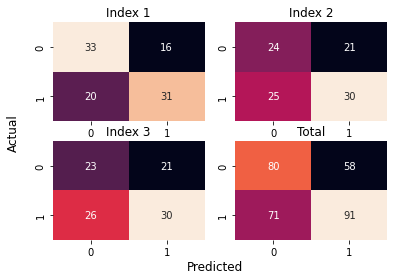

In [9]:
plot_confusion_matrix(models[0]['cm'])

In [10]:
print_effectiveness_by_day(models[0]['cm'])

Day: 1 Accuracy: 0.64
Day: 2 Accuracy: 0.54
Day: 3 Accuracy: 0.53
